In [1]:
import numpy as np
import xarray as xr
import netCDF4
import os
import datetime
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib import cm
import seaborn as sns
import shutil
from datetime import datetime, timedelta
import glob
import datetime as dt
from os import path
import cartopy.crs as ccrs
import fsspec
import sys
import seaborn as sns
import os
from datetime import timezone
from scipy.stats import rankdata
xr.set_options(keep_attrs=True)
plt.style.use('dark_background')
import rioxarray as rio
#import xesmf as xe
import pandas as pd

# AUTHOR INFORMATION

Author: Martin Wegmann

Contact: martin.wegmann@unibe.ch

Data availability: Data is from Marty, C., Michel, A., Jonas, T. (2025). SPASS - new gridded climatological snow datasets for Switzerland. EnviDat. https://www.doi.org/10.16904/envidat.580.

Based on: https://egusphere.copernicus.org/preprints/2025/egusphere-2025-413/

Goal: Goal of this notebook is to create plots that communicate the snow depth evolution over Switzerland with time. This is a partner project with https://www.unisg.ch/.

# FUNCTIONS

In [2]:
def plotting_ranked_heatmap(data,variable,plot_folder,cmap,ranked_pos=True):
    years=np.unique(data.time.dt.year.values)
    amount_years=len(years)
    last_month=data[variable].time.dt.month[-1].values
    last_year=data[variable].time.dt.year[-1].values
    x = np.arange(1974,last_year+1,2)
    strings = ["%.0f" % number for number in x]
    last_month=data[variable].time.dt.month[-1].values
    last_year=data[variable].time.dt.year[-1].values
    if last_month!=1:
        if ranked_pos==True:
            values=data[variable].values[:-1]
            b=np.repeat(-9999,12+1-last_month)
            values=data[variable].values[:-1]
            c=np.repeat(np.nan,12+1-last_month)
            values_NAN=np.concatenate((values, c), axis=None)
            values_9999=np.concatenate((values, b), axis=None)
            values_NAN_reshaped=values_NAN.reshape(amount_years,12)
            values_9999_reshaped=values_9999.reshape(amount_years,12)
        else:
            values=data[variable].values[:-1]
            b=np.repeat(9999,12+1-last_month)
            values=data[variable].values[:-1]
            c=np.repeat(np.nan,12+1-last_month)
            values_NAN=np.concatenate((values, c), axis=None)
            values_9999=np.concatenate((values, b), axis=None)
            values_NAN_reshaped=values_NAN.reshape(amount_years,12)
            values_9999_reshaped=values_9999.reshape(amount_years,12)

        reshaped_data_climatology=data[variable].sel(time=slice("1981-01-31","2010-12-31")).values.reshape(30,12)
        average_monthly_value=reshaped_data_climatology.mean(axis=0)
        
        monthly_anomalies_nan=values_NAN_reshaped-average_monthly_value
        monthly_anomalies_9999=values_9999_reshaped-average_monthly_value
        empty_ranks=np.zeros_like(monthly_anomalies_nan)





        empty_ranks=np.zeros_like(monthly_anomalies_nan)
        if ranked_pos==True:
            for i in range(12):
                empty_ranks[:,i]=(rankdata(monthly_anomalies_9999[:,i])-amount_years)*-1+1
        else:
            for i in range(12):
                empty_ranks[:,i]=rankdata(monthly_anomalies_9999[:,i])
        ranks_first=empty_ranks==1*1
        ranks_second=(empty_ranks==2)*2
        ranks_third=(empty_ranks==3)*3
        ranks_third=ranks_third.astype('float')
        ranks_second=ranks_second.astype('float')
        ranks_first=ranks_first.astype('float')
        ranks_third[ranks_third==0]=np.nan
        ranks_second[ranks_second==0]=np.nan
        ranks_first[ranks_first==0]=np.nan
        vmax=round(np.nanmax(monthly_anomalies_nan),4)
        
        
    else:
        reshaped_data_climatology=data[variable].sel(time=slice("1981-01-31","2010-12-31")).values.reshape(30,12)
        average_monthly_value=reshaped_data_climatology.mean(axis=0)
        values=data[variable].values[:-1]

        monthly_anomalies_nan=values.reshape(amount_years-1,12)-average_monthly_value
        monthly_anomalies_9999=values.reshape(amount_years-1,12)-average_monthly_value
        empty_ranks=np.zeros_like(monthly_anomalies_nan)





        empty_ranks=np.zeros_like(monthly_anomalies_nan)
        if ranked_pos==True:
            for i in range(12):
                empty_ranks[:,i]=(rankdata(monthly_anomalies_9999[:,i])-amount_years)*-1+1
        else:
            for i in range(12):
                empty_ranks[:,i]=rankdata(monthly_anomalies_9999[:,i])
        ranks_first=empty_ranks==1*1
        ranks_second=(empty_ranks==2)*2
        ranks_third=(empty_ranks==3)*3
        ranks_third=ranks_third.astype('float')
        ranks_second=ranks_second.astype('float')
        ranks_first=ranks_first.astype('float')
        ranks_third[ranks_third==0]=np.nan
        ranks_second[ranks_second==0]=np.nan
        ranks_first[ranks_first==0]=np.nan
        vmax=round(np.nanmax(monthly_anomalies_nan),4)

    
    fig, axs = plt.subplots(1, 1, figsize=(10.2,3.2), dpi= 300)
    ax = sns.heatmap(monthly_anomalies_nan.transpose(), linewidth=0.5, linecolor='black',vmin=vmax*-1,vmax=vmax,cmap=cmap)
    ax = sns.heatmap(ranks_third.transpose(), linewidth=0.5, linecolor='black',cmap=cmap,alpha=0, cbar=False, annot=True)
    ax = sns.heatmap(ranks_second.transpose(), linewidth=0.5, linecolor='black',cmap=cmap,alpha=0, cbar=False, annot=True)
    ax = sns.heatmap(ranks_first.transpose(), linewidth=0.5, linecolor='black',cmap=cmap,alpha=0, cbar=False, annot=True)
    ax.set(xlabel="Year", ylabel="Month")
    ax.set_yticklabels(["01","02" ,"03","04","05","06","07","08","09","10","11","12"])
    ax.set_yticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"])
    ax.set_xticklabels(strings)
    ax.set_xticks([0.5,10.5,20.5,30.5,40.5])


    ax.set_xticklabels(["1973","1983","1993","2003","2014"])
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 0)
    plt.title("Switzerland mean monthly snow depth anomalies wrt 1981-2010")
    cbar = ax.collections[0].colorbar
    cbar.set_label('[m]', fontsize=12)  
    plt.tight_layout()
    save_name="ERA5_heatmap_"+variable
    plt.savefig(plot_folder+save_name+".pdf")
    plt.savefig(plot_folder+save_name+".png")
    plt.show()
    return 

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_anom_ts_2d(data, var, plot_folder, cmap, resolution, ncols=10):
    data2plot = data[var]
    maxmin = [data2plot.max().values, data2plot.min().values]
    range = np.max(np.abs(maxmin))
    years = np.unique(data.year.values)
    
    print(data2plot.shape)
    
    plot = data2plot.plot(
        vmax=1,
        vmin=-1,
        #vmax=range,
        #vmin=-range,
        cmap=cmap,
        levels=8,
        col="year",
        col_wrap=ncols
    )
    
    for i, ax in enumerate(plot.axs.flat):
        year_title = i + 1973
        ax.set_title(str(year_title))
        
        # Remove all ticks and labels
        ax.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False
        )
        
        # Remove axis label descriptions (e.g., "longitude", "latitude")
        ax.set_xlabel("")
        ax.set_ylabel("")

    plot.cbar.ax.tick_params(labelsize=20)  # Tick label size
    plot.cbar.set_label("[m]", fontsize=20)  # Set colorbar label (edit as needed)

    plt.draw()
    plt.savefig(f"{plot_folder}{var}_{resolution}_anoms.png")
    plt.savefig(f"{plot_folder}{var}_{resolution}_anoms.pdf")
    print(f"Stored in {plot_folder}{var}_{resolution}_anoms.png")
    return


In [4]:
def max_consecutive_ones_in_da(da_year):
    diff = da_year.astype(int).diff(dim='time')

    first_time = da_year.time.values[0]
    prepend = xr.DataArray([1], dims=['time'], coords={'time': [first_time]})

    change = xr.concat([prepend, diff], dim='time').astype(bool)

    groups = change.cumsum(dim='time')
    groups = groups.assign_coords(time=da_year.time)

    grouped = da_year.groupby(groups)
    run_lengths = [group.sum().item() for _, group in grouped if group[0].item() == 1]

    max_len = max(run_lengths) if run_lengths else 0

    # Return as xarray.DataArray scalar
    return xr.DataArray(max_len)

In [5]:
# Step 2: Function to get bin edges from da2 coords
def get_bin_edges(coords):
    edges = (coords[:-1].values + coords[1:].values) / 2
    start_edge = coords.values[0] - (edges[0] - coords.values[0])
    end_edge = coords.values[-1] + (coords.values[-1] - edges[-1])
    return np.concatenate(([start_edge], edges, [end_edge]))

In [6]:
# Step 4: Convert IntervalIndex bin coords to bin centers for numeric coords
def interval_to_center(dataarray):
    # Convert coordinate DataArray to pandas IntervalIndex
    intervals = dataarray.variable.to_index()
    return [(interval.left + interval.right) / 2 for interval in intervals]


# SETUP

In [7]:
data_folder="/Volumes/SPARK3/meteo_swiss/snow/"
plot_folder=data_folder+"plots/"

In [8]:
# Swiss Coordinates of Locations taken of wikipedia
# ZRH
# 2683484.331,1247341.058
# Bellinzona
# 2722637.588,1117130.525
# Zermatt
# 2624264.205,1096736.840
# St Moritz
# 2784248.087,1152506.491
# Davos
# 2782998.931,1186335.249
# Sion
# 2594285.321,1119595.431
#.sel(E=2683484.331,N=1247341.058,method="nearest"

# Bern E = 2,600,000 and N = 1,200,000
# geneva E=2500532, N=1117325
# Lausanne E=2538291, N=1152330
# adelboden E=2609302, N=1149113
# verbier E=2583788, N=1104968

# READ IN DATA

## SNOW DATA

In [9]:
CH_SD_original=xr.open_dataset(data_folder+"HSCLQMD_ch01h.swiss.lv95_WY_1962_2023.nc")

### postprocessing

In [10]:
# Focus on the last complete 50 years 
CH_SD=CH_SD_original.sel(time=(slice("1973","2022")))

In [11]:
# city extraction
CH_SD_bern=CH_SD.sel(E=2600000,N=1200000,method="nearest")
CH_SD_bern_christmas=CH_SD_bern.sel(time=(CH_SD_bern['time'].dt.month == 12) & (CH_SD_bern['time'].dt.day == 25))>0.0001

In [12]:
# city extraction
CH_SD_geneva=CH_SD.sel(E=2500532,N=1117325,method="nearest")
CH_SD_geneva_christmas=CH_SD_geneva.sel(time=(CH_SD_geneva['time'].dt.month == 12) & (CH_SD_geneva['time'].dt.day == 25))>0.0001

In [13]:
# city extraction
CH_SD_lausanne=CH_SD.sel(E=2538291,N=1152330,method="nearest")
CH_SD_lausanne_christmas=CH_SD_lausanne.sel(time=(CH_SD_lausanne['time'].dt.month == 12) & (CH_SD_lausanne['time'].dt.day == 25))>0.0001

In [14]:
# city extraction
CH_SD_zurich=CH_SD.sel(E=2683484.331,N=1247341.058,method="nearest")
CH_SD_zurich_christmas=CH_SD_zurich.sel(time=(CH_SD_zurich['time'].dt.month == 12) & (CH_SD_zurich['time'].dt.day == 25))>0.0001

In [15]:
# city extraction
CH_SD_basel=CH_SD.sel(E=2611220,N=1267503,method="nearest")
CH_SD_basel_christmas=CH_SD_basel.sel(time=(CH_SD_basel['time'].dt.month == 12) & (CH_SD_basel['time'].dt.day == 25))>0.0001

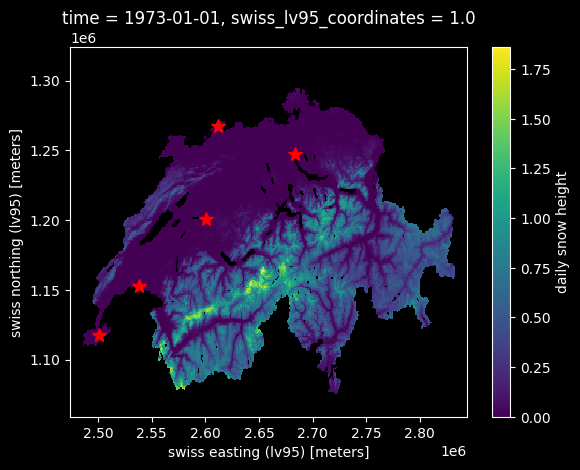

In [16]:
CH_SD.isel(time=0).HSCLQMD.plot()
plt.plot(CH_SD_bern.E.values, CH_SD_bern.N.values, marker='*', color='red', markersize=10)
plt.plot(CH_SD_geneva.E.values, CH_SD_geneva.N.values, marker='*', color='red', markersize=10)
plt.plot(CH_SD_lausanne.E.values, CH_SD_lausanne.N.values, marker='*', color='red', markersize=10)
plt.plot(CH_SD_zurich.E.values, CH_SD_zurich.N.values, marker='*', color='red', markersize=10)
plt.plot(CH_SD_basel.E.values, CH_SD_basel.N.values, marker='*', color='red', markersize=10)

# PLOTTING

## Snow in cities on Christmas 1/0

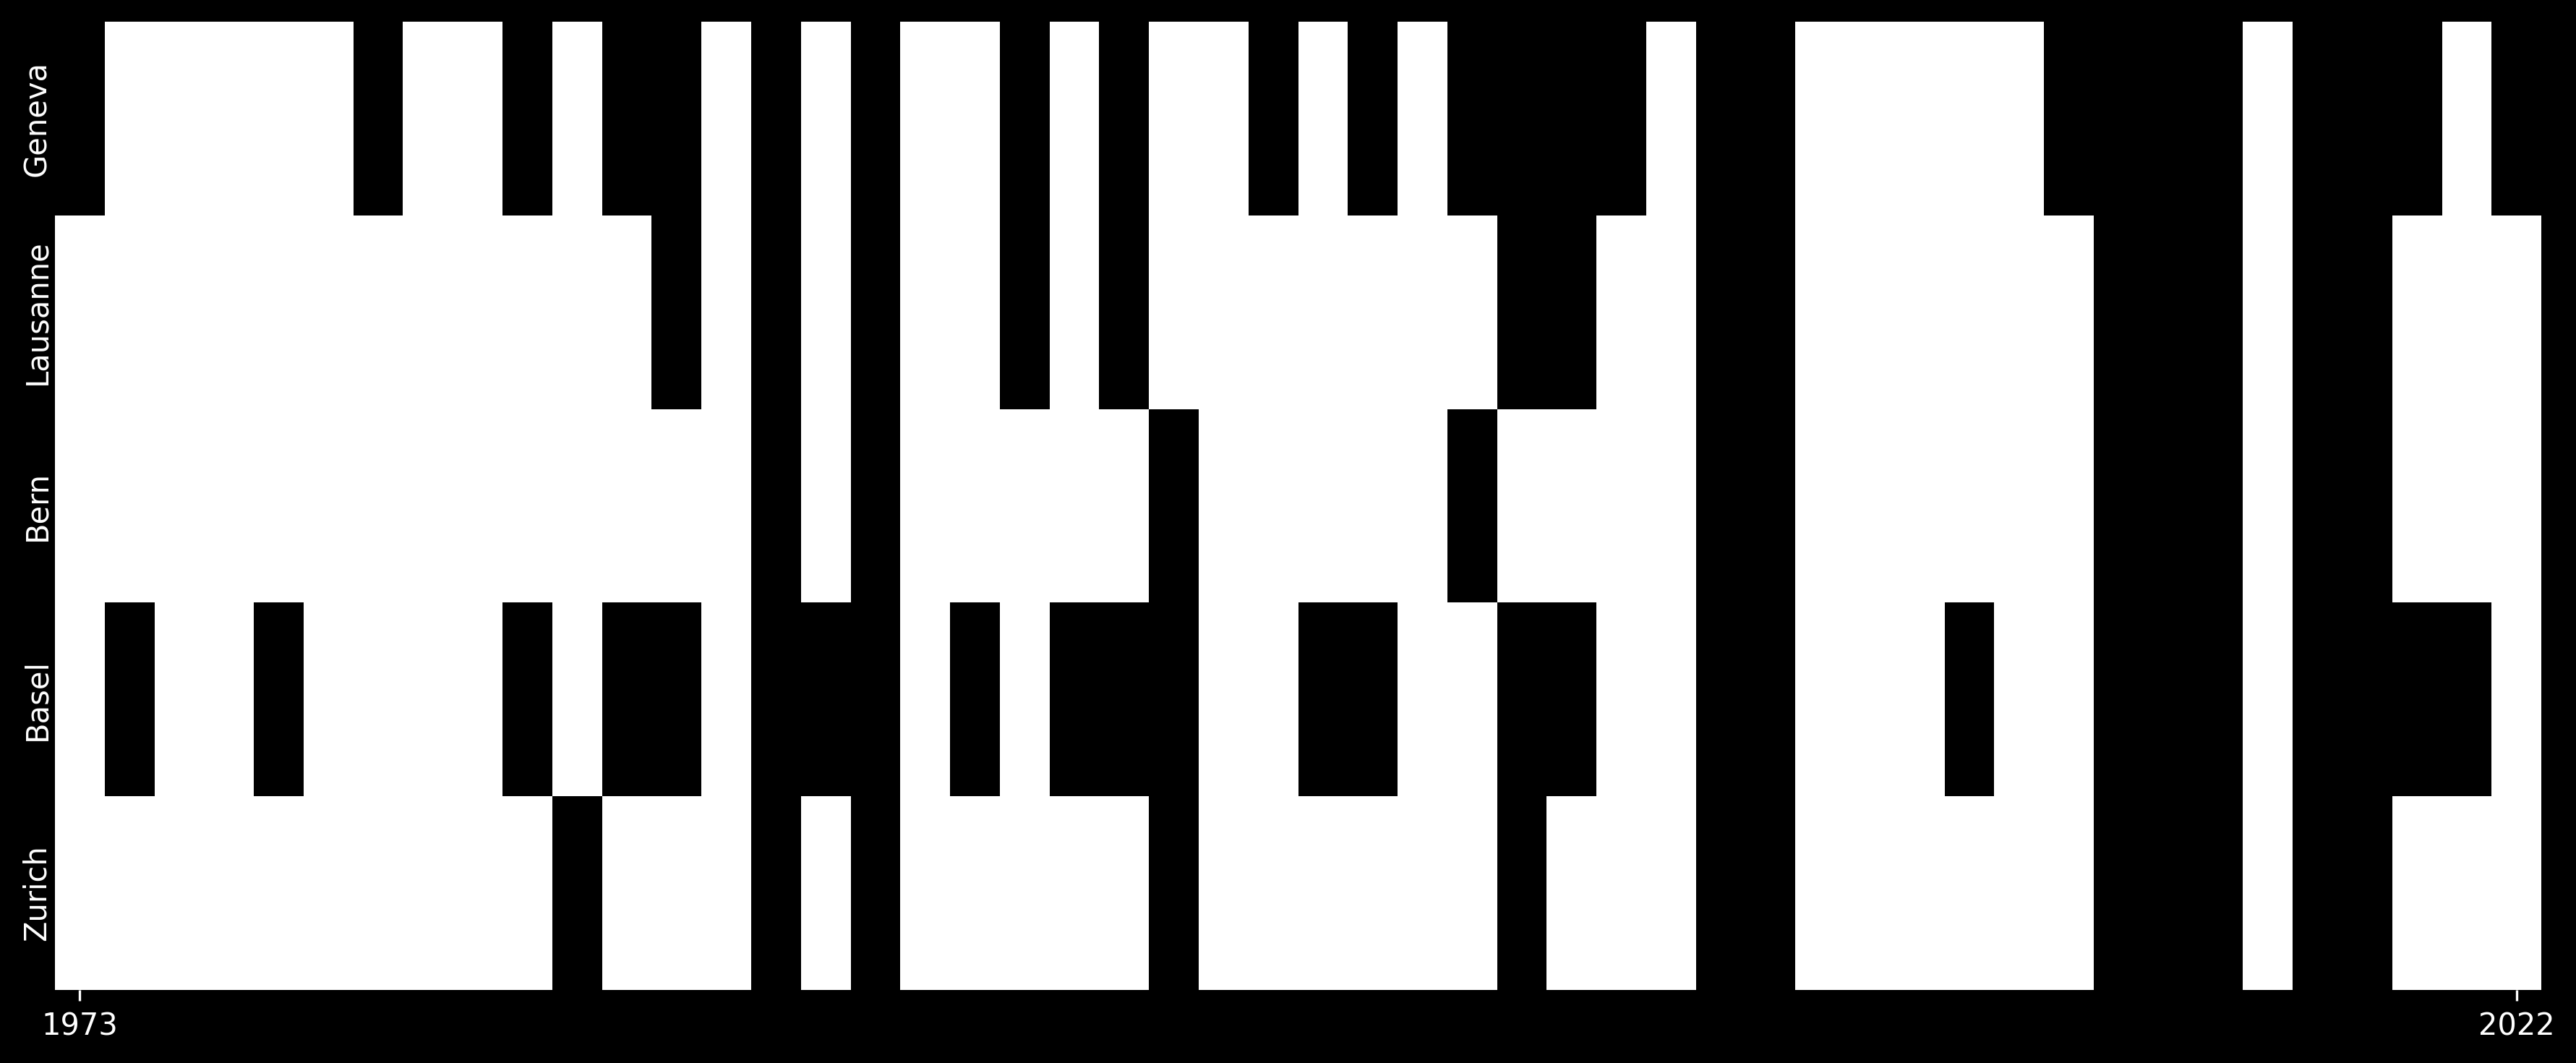

In [17]:


# Example inputs (replace these with your actual datasets and city names)
datasets = [
    CH_SD_geneva_christmas.HSCLQMD,
    CH_SD_lausanne_christmas.HSCLQMD,
    CH_SD_bern_christmas.HSCLQMD,
    CH_SD_basel_christmas.HSCLQMD,
    CH_SD_zurich_christmas.HSCLQMD,
    # Add more datasets as needed
]

city_names = [
    "Geneva",
    "Lausanne",
    "Bern",
    "Basel",
    "Zurich",
    # Add more names corresponding to datasets
]

n = len(datasets)
if len(city_names) != n:
    raise ValueError("datasets and city_names must be the same length")

fig = plt.figure(figsize=(12, n), dpi=300)  # Height scales with number of plots

gs = gridspec.GridSpec(nrows=n, ncols=1, height_ratios=[1]*n, hspace=0)

for i in range(n):
    ax = fig.add_subplot(gs[i])
    
    data_array = datasets[i]
    data_reshaped = data_array.values.reshape(1, -1)
    
    sns.heatmap(data_reshaped, cmap="binary_r", cbar=False,
                xticklabels=False, yticklabels=False, ax=ax)
    
    ax.set_ylabel(city_names[i], rotation=90, ha='center', va='center', fontsize=10, labelpad=6)
    
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    if i == n - 1:
        ax.set_xticks([0.5, data_reshaped.shape[1] - 0.5])
        ax.set_xticklabels([
            data_array.time.dt.year.values[0],
            data_array.time.dt.year.values[-1]
        ])
    else:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.tight_layout()
plt.savefig(plot_folder + "city_christmas_stacked.png")
plt.savefig(plot_folder + "city_christmas_stacked.pdf")
plt.show()


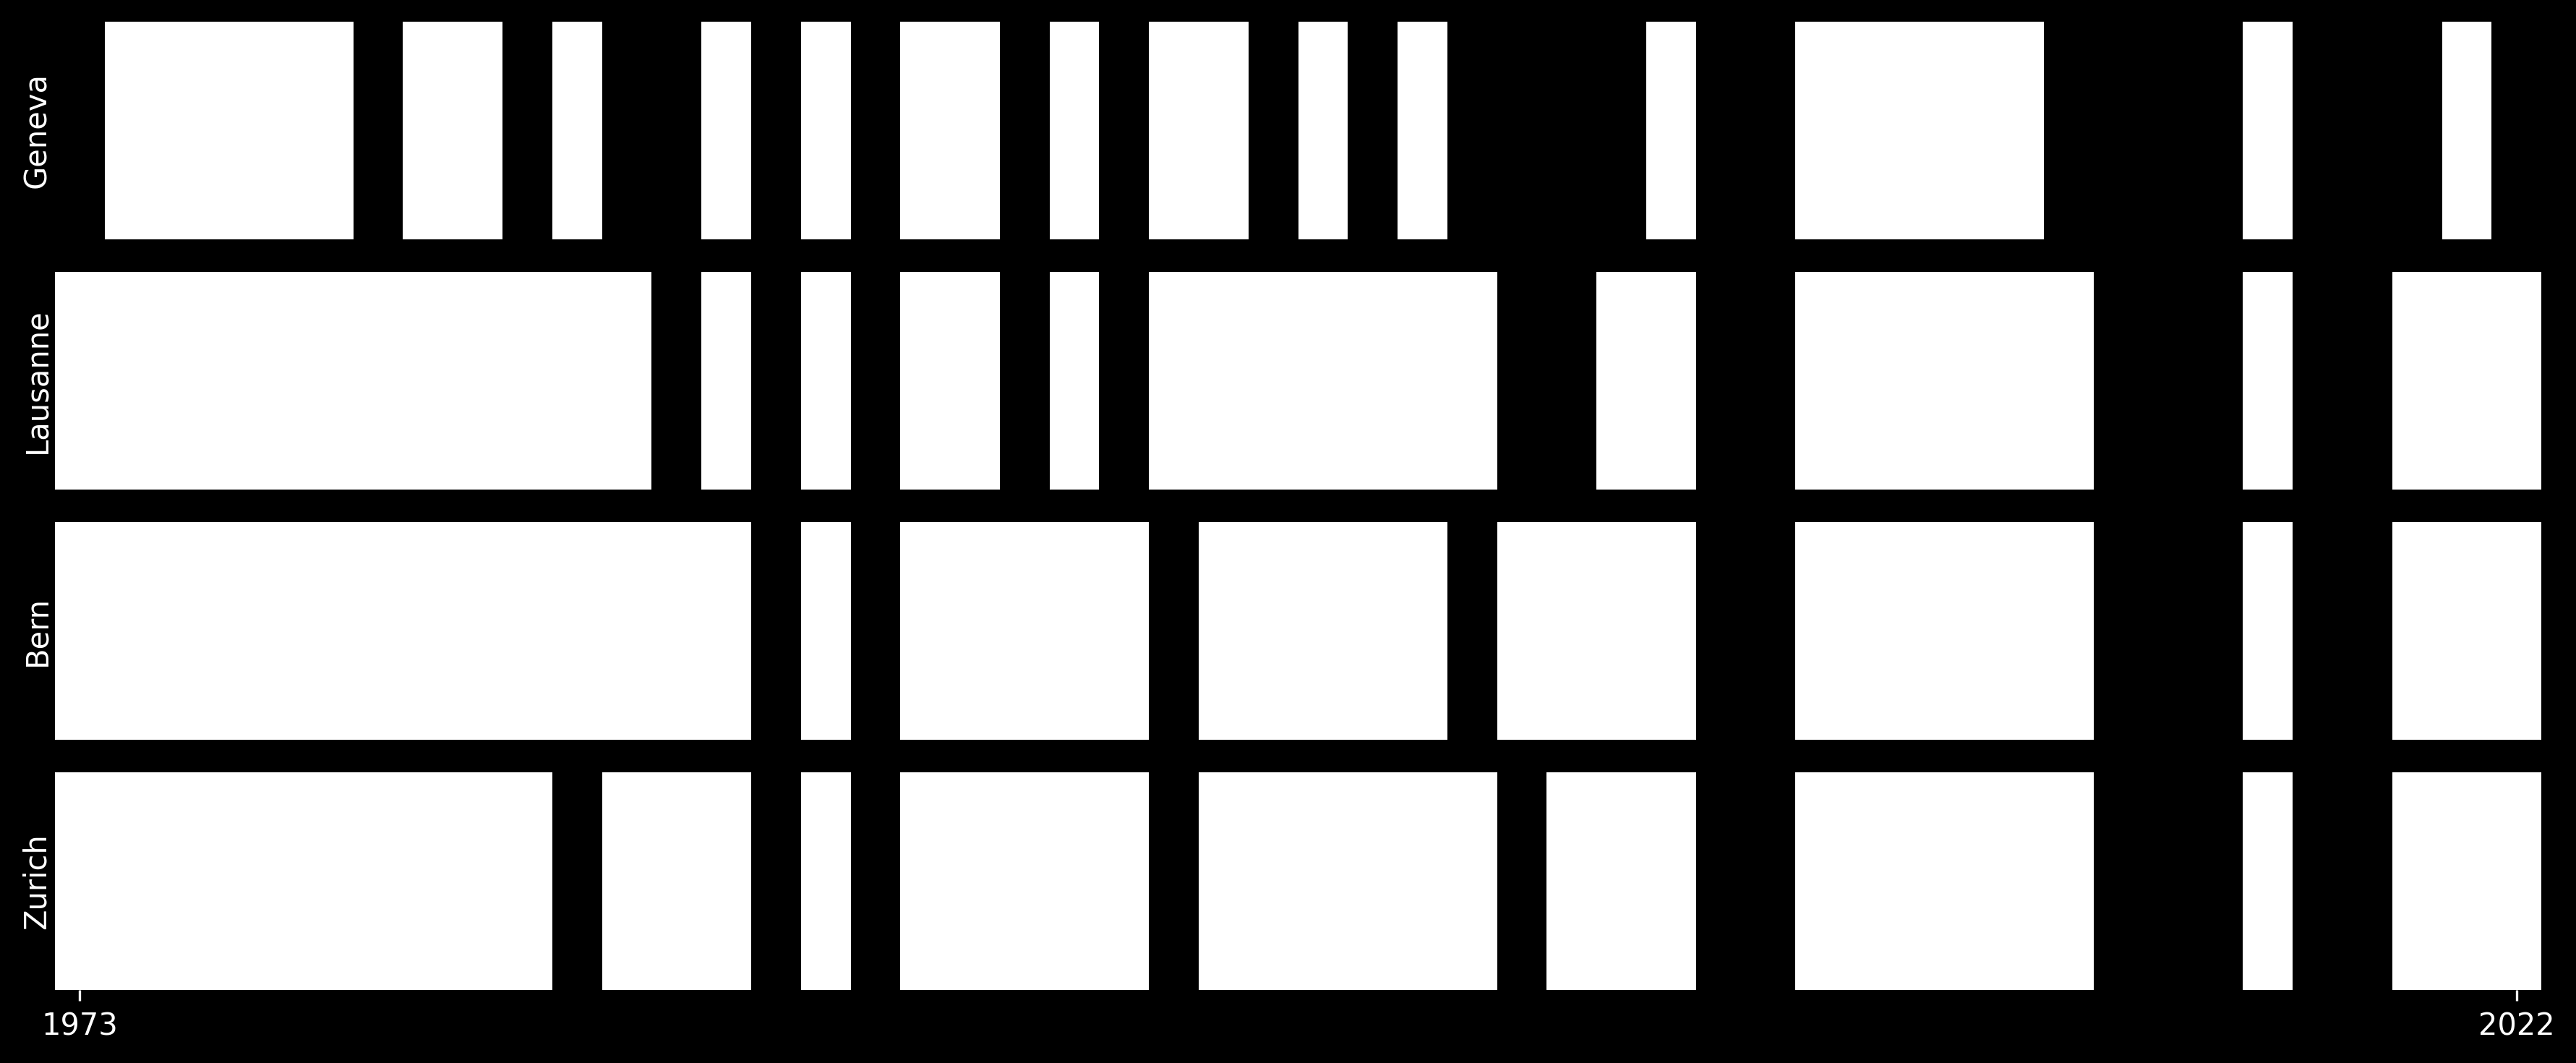

In [18]:


# Example list of xarray DataArrays
datasets = [
    CH_SD_geneva_christmas.HSCLQMD,
    CH_SD_lausanne_christmas.HSCLQMD,
    CH_SD_bern_christmas.HSCLQMD,
    CH_SD_zurich_christmas.HSCLQMD
]

# Corresponding city names
city_names = ["Geneva", "Lausanne", "Bern", "Zurich"]

# Create figure with 4 subplots
fig, axes = plt.subplots(nrows=4, figsize=(12, 5), dpi=300, sharex=True)

# Loop through datasets and axes
for i, (data_array, ax) in enumerate(zip(datasets, axes)):
    # Reshape to 2D: 1 row x N columns
    data_reshaped = data_array.values.reshape(1, -1)
    
    # Plot the heatmap
    sns.heatmap(data_reshaped, cmap="binary_r", cbar=False,
                xticklabels=False, yticklabels=False, ax=ax)
    
    # Set y-axis label to the city name
    ax.set_ylabel(city_names[i], rotation=90, ha='center', va='center', fontsize=10, labelpad=6)
    
    # Hide spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Only show x-axis ticks on the bottom plot
    if i == len(datasets) - 1:
        ax.set_xticks([0.5, data_reshaped.shape[1] - 0.5])
        ax.set_xticklabels([
            data_array.time.dt.year.values[0],
            data_array.time.dt.year.values[-1]
        ])
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adjust layout to remove vertical space
plt.subplots_adjust(hspace=0)
plt.tight_layout()


plt.savefig(plot_folder + "city_christmas_stacked_gap.png")
plt.savefig(plot_folder + "city_christmas_stacked_gap.pdf")
plt.show()